# Import 

In [86]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('python')

In [87]:
from utils import (
    show_images,
    save_model_weights,
    load_model_weights,
    submission_generate_images,
    seed_everything,
    get_device,
    count_parameters,
    show_generate_imgs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm_notebook
import os
import numpy as np
import matplotlib.pyplot as plt

from dataset import MotorbikeDataset, get_transforms
from layers import init_weight, conv1x1, conv3x3, Attention, ConditionalNorm

# Dataloader

In [4]:
base_tfs, additional_tfs = get_transforms()
data_path = 'data/resized128_image/'
ds = MotorbikeDataset(data_path, base_tfs, additional_tfs)

In [5]:
tensors = ds.sample()
images = [np.transpose((t.numpy() + 1) / 2.0, [1, 2, 0]) for t in tensors]

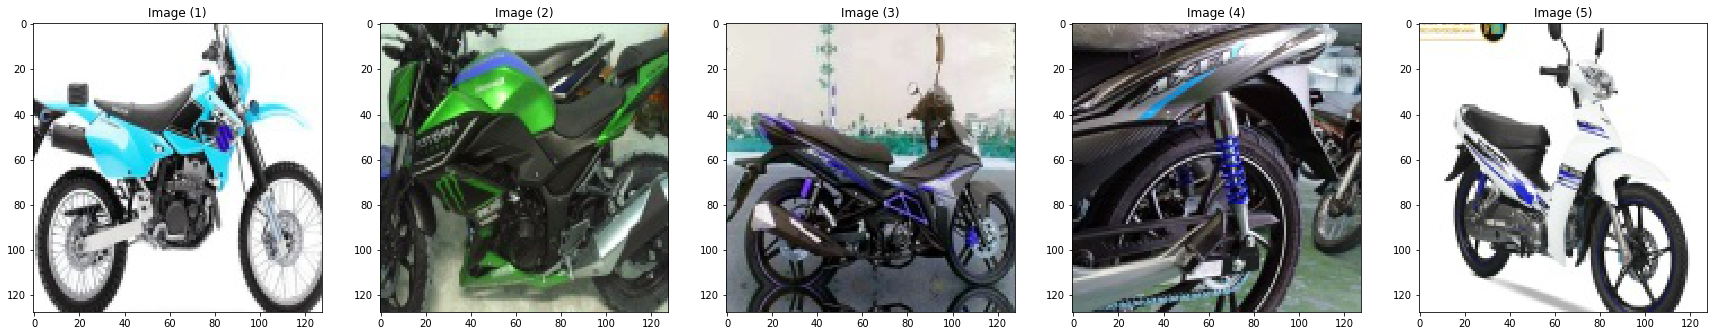

In [6]:
show_images(images)

# Model

In [168]:
#BigGAN + leaky_relu           
class ResBlock_G(nn.Module):
    def __init__(self, in_channel, out_channel, condition_dim, upsample=True):
        super().__init__()
        self.cbn1 = ConditionalNorm(in_channel, condition_dim)
        self.upsample = nn.Sequential()
        if upsample:
            self.upsample.add_module('upsample',nn.Upsample(scale_factor=2, mode='nearest'))
        self.conv3x3_1 = nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight)
        self.cbn2 = ConditionalNorm(out_channel, condition_dim)
        self.conv3x3_2 = nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight) 
        self.conv1x1   = nn.utils.spectral_norm(conv1x1(in_channel, out_channel)).apply(init_weight)
        
    def forward(self, inputs, condition):
        x  = F.leaky_relu(self.cbn1(inputs, condition))
        x  = self.upsample(x)
        x  = self.conv3x3_1(x)
        x  = self.conv3x3_2(F.leaky_relu(self.cbn2(x, condition)))
        x += self.conv1x1(self.upsample(inputs)) #shortcut
        return x

class Generator(nn.Module):
    def __init__(self, n_feat, codes_dim, n_classes=0):
        super().__init__()
        self.codes_dim = codes_dim
        self.fc   = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(codes_dim, 16*n_feat*4*4)).apply(init_weight)
        )
        self.res1 = ResBlock_G(16*n_feat, 16*n_feat, codes_dim+n_classes, upsample=True)
        self.res2 = ResBlock_G(16*n_feat,  8*n_feat, codes_dim+n_classes, upsample=True)
        self.res3 = ResBlock_G( 8*n_feat,  4*n_feat, codes_dim+n_classes, upsample=True)
        self.attn = Attention(  2*n_feat)
        self.res4 = ResBlock_G( 4*n_feat,  2*n_feat, codes_dim+n_classes, upsample=True)
        self.res5 = ResBlock_G( 2*n_feat,  n_feat, codes_dim+n_classes, upsample=True)
        self.conv = nn.Sequential(
            #nn.BatchNorm2d(2*n_feat).apply(init_weight),
            nn.LeakyReLU(),
            nn.utils.spectral_norm(conv3x3(n_feat, 3)).apply(init_weight),
        )
        
    def forward(self, z):
        '''
        z.shape = (*,Z_DIM)
        cd.shape = (*,n_classes)
        '''
        batch = z.size(0)
        z = z.squeeze()
#         label_ohe = label_ohe.squeeze()
        codes = torch.split(z, self.codes_dim, dim=1)
        
        x = self.fc(codes[0]) #->(*,16ch*4*4)
        x = x.view(batch,-1,4,4) #->(*,16ch,4,4)
        
        condition = torch.cat([codes[1]], dim=1) #(*,codes_dim+n_classes)
        x = self.res1(x, condition)#->(*,16ch,8,8)
        
        condition = torch.cat([codes[2]], dim=1)
        x = self.res2(x, condition) #->(*,8ch,16,16)
        
        condition = torch.cat([codes[3]], dim=1)
        x = self.res3(x, condition) #->(*,4ch,32,32)
        
        condition = torch.cat([codes[4]], dim=1)
        x = self.res4(x, condition) #->(*,2ch,64,64)
        x = self.attn(x) #not change shape
        
        condition = torch.cat([codes[5]], dim=1)
        x = self.res5(x, condition) #->(*,2ch,128,128)
        
        x = self.conv(x) #->(*,3,128,128)
        x = torch.tanh(x)
        return x
    

class ResBlock_D(nn.Module):
    def __init__(self, in_channel, out_channel, downsample=True):
        super().__init__()
        self.layer = nn.Sequential(
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(in_channel, out_channel)).apply(init_weight),
            nn.LeakyReLU(0.2),
            nn.utils.spectral_norm(conv3x3(out_channel, out_channel)).apply(init_weight),
        )
        self.shortcut = nn.Sequential(
            nn.utils.spectral_norm(conv1x1(in_channel,out_channel)).apply(init_weight),
        )
        if downsample:
            self.layer.add_module('avgpool',nn.AvgPool2d(kernel_size=2,stride=2))
            self.shortcut.add_module('avgpool',nn.AvgPool2d(kernel_size=2,stride=2))
        
    def forward(self, inputs):
        x  = self.layer(inputs)
        x += self.shortcut(inputs)
        return x
    

class Discriminator(nn.Module):
    def __init__(self, n_feat, activate_fnc=None):
        super().__init__()
        self.res1 = ResBlock_D(3, n_feat, downsample=True)
        self.attn = Attention(n_feat)
        self.res2 = ResBlock_D(  n_feat, 2*n_feat, downsample=True)
        self.res3 = ResBlock_D(2*n_feat, 4*n_feat, downsample=True)
        self.res4 = ResBlock_D(4*n_feat, 8*n_feat, downsample=True)
        self.res5 = ResBlock_D(8*n_feat,16*n_feat, downsample=True)
        self.res6 = ResBlock_D(16*n_feat,32*n_feat, downsample=False)
        self.activate_fnc = activate_fnc
        
        self.fc   = nn.utils.spectral_norm(nn.Linear(32*n_feat,1)).apply(init_weight)
        
    def forward(self, inputs):
        batch = inputs.size(0) #(*,3,128,128)
        h = self.res1(inputs) #->(*,ch,64,64)
        h = self.attn(h) #not change shape
        h = self.res2(h) #->(*,2ch,32,32)
        h = self.res3(h) #->(*,4ch,16,16)
        h = self.res4(h) #->(*,8ch,8,8)
        h = self.res5(h) #->(*,16ch,4,4)
        h = self.res6(h) #->(*,32ch,4,4)
        
        h = torch.sum((F.leaky_relu(h,0.2)).view(batch,-1,4*4), dim=2) #GlobalSumPool ->(*,16ch)
        outputs = self.fc(h) #->(*,1)

        if self.activate_fnc == 'hinge':
            outputs = torch.sigmoid(outputs)
            
        return outputs

In [190]:
class Trainer:
    def __init__(self, params):
        self.params = params
        
        default_params = {
            'lr_D': 3e-4,
            'lr_G': 3e-4,
            'beta1': 0,
            'beta2': 0.999,
            'nz': 120,
            'n_iter_D': 1,
            'model_path': 'models'
        }
        
        for k in default_params.keys():
            if k not in params:
                params[k] = default_params[k]
        
        for k, v in params.items():
            setattr(self, k, v)
        self.init()
        self.current_epoch = 0
        
            
    def init(self):
        self.build_models()
        self.get_optimizers()
        
    
    def build_models(self):
        self.netG = Generator(n_feat=8, codes_dim=CODES_DIM) #z.shape=(*,120)
        self.netD = Discriminator(n_feat=8)
        
    def get_optimizers(self):
        self.optimizerD = optim.Adam(self.netD.parameters(), lr=self.lr_D, betas=(self.beta1, self.beta2))
        self.optimizerG = optim.Adam(self.netG.parameters(), lr=self.lr_G, betas=(self.beta1, self.beta2))
        
    def resume(self, file_name):
        checkpoint = torch.load(file_name)
        self.netD.load_state_dict(checkpoint['netD'])
        self.netG.load_state_dict(checkpoint['netG'])
        self.optimizerD.load_state_dict(checkpoint['optimizer_D'])
        self.optimizerG.load_state_dict(checkpoint['optimizer_G'])
        
        self.current_epoch = checkpoint['epoch']
        print("Loaded successfullly save models")
        
    def save(self, filename):
        current_state = {
               'netG': self.netG.state_dict(),
               'netD': self.netD.state_dict(),
               'optimizer_D': self.optimizerD.state_dict(),
               'optimizer_G': self.optimizerG.state_dict(),
               'epoch': self.current_epoch
        }
        print(f"Saved model to {filename}")
        torch.save(current_state, filename)
        
    def train_loop(self, dl, epochs=2, output_freq=1):
        device = get_device()        
        netD = self.netD.to(device)
        netG = self.netG.to(device)
        n_ite_D = self.n_iter_D
        nz = self.nz

        print(count_parameters(netG))
        print(count_parameters(netD))

        real_label = 0.9
        fake_label = 0

        D_loss_list = []
        G_loss_list = []

        dis_criterion = nn.BCELoss().to(device)
        optimizerD = self.optimizerD
        optimizerG = self.optimizerG

        if MILESTONES is not None:
            schedulerD = optim.lr_scheduler.MultiStepLR(self.optimizerD, milestones=MILESTONES, 
                                                        gamma=SCHEDULER_GAMMA, last_epoch=-1)
            schedulerG = optim.lr_scheduler.MultiStepLR(self.optimizerG, milestones=MILESTONES, 
                                                        gamma=SCHEDULER_GAMMA, last_epoch=-1)
        fixed_noise = torch.randn(32, self.nz, 1, 1, device=device)
        netG.train()
        netD.train()

        # training here
        for epoch in range(1,epochs+1):
            if MILESTONES is not None:
                print('lrG = ', schedulerG.get_lr()[0])
                print('lrD = ', schedulerD.get_lr()[0])
            D_running_loss = 0
            G_running_loss = 0
            
            for ii, data in tqdm_notebook(enumerate(dl), total=len(dl)):
                ############################
                # (1) Update D network
                ###########################
                for _ in range(n_ite_D):
                    if LABEL_NOISE:
                        real_label = 0.9
                        fake_label = 0
                        if np.random.random() < LABEL_NOISE_PROB:
                            real_label = 0
                            fake_label = 0.9
                    # train with real
                    netD.zero_grad()
                    real_images = data.to(device, non_blocking=True) 
                    batch_size  = real_images.size(0)
                    dis_labels  = torch.full((batch_size, 1), real_label, device=device) #shape=(*,)
    #                 aux_labels  = data['label'].long().to(device, non_blocking=True) #shape=(*,)
                    dis_output  = netD(real_images) #dis shape=(*,1)
                    if HINGE_LOSS:
                        errD_real = torch.mean(F.relu(1-dis_output))
                    else:
                        errD_real  = dis_criterion(dis_output, dis_labels)
                    errD_real.backward(retain_graph=True)

    #                 # train with fake
                    noise  = torch.randn(batch_size, nz, 1, 1, device=device)
    #                 #noise = noise / noise.norm(dim=1, keepdim=True)
    #                 aux_labels     = np.random.randint(0,n_classes, batch_size)
    #                 aux_labels_ohe = np.eye(n_classes)[aux_labels]
    #                 aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
    #                 aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
    #                 aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)

                    fake = netG(noise) #output shape=(*,3,64,64)
                    dis_labels.fill_(fake_label)
                    dis_output = netD(fake.detach())
                    if HINGE_LOSS:
                        errD_fake = torch.mean(F.relu(1+dis_output))
                    else:
                        errD_fake  = dis_criterion(dis_output, dis_labels)
                    errD_fake.backward(retain_graph=True)
                    D_running_loss += (errD_real.item() + errD_fake.item())/len(train_loader)
                    optimizerD.step()

                ############################
                # (2) Update G network
                ###########################
                netG.zero_grad()
                dis_labels.fill_(real_label)  # fake labels are real for generator cost
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
    #             aux_labels     = np.random.randint(0,n_classes, batch_size)
    #             aux_labels_ohe = np.eye(n_classes)[aux_labels]
    #             aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
    #             aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
    #             aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
                fake  = netG(noise)

                dis_output = netD(fake)
                if HINGE_LOSS:
                    errG = - torch.mean(dis_output)
                else:
                    errG   = dis_criterion(dis_output, dis_labels)
                errG.backward(retain_graph=True)
                G_running_loss += errG.item()/len(train_loader)
                optimizerG.step()

            if MILESTONES is not None:
                schedulerD.step()
                schedulerG.step()

            if EMA == True:
                print("Setup EMA")
                for name, param in netG.named_parameters():
                    if param.requires_grad:
                        param.data = ema(name, param.data)

            #log
            D_loss_list.append(D_running_loss)
            G_loss_list.append(G_running_loss)

            #output
            if epoch % output_freq == 0:
                print('[{:d}/{:d}] D_loss = {:.3f}, G_loss = {:.3f}, elapsed_time = ? min'.format(epoch,epochs,D_running_loss,G_running_loss))

                show_generate_imgs(netG,fixed_noise)
                plt.show()
                
                self.save(os.path.join(self.model_path, f'model_{epoch}.pth'))

            if epoch % 20 == 0:
    #             if not EMA:
                torch.save(netG.state_dict(), f'generator_epoch{epoch}.pth')
    #             elif EMA:
    #                 torch.save(netG_EMA.state_dict(), f'generator_epoch{epoch}.pth')

    #     if not EMA:
    #         torch.save(netG.state_dict(), 'generator.pth')
    #     elif EMA:
    #         torch.save(netG_EMA.state_dict(), 'generator.pth')
    #     torch.save(netD.state_dict(), 'discriminator.pth')

        res = {'netG':netG,
               'netD':netD,
               'nz':nz,
               'optimizer_D': optimizerD,
               'optimizer_G': optimizerG,
               'D_loss_list':D_loss_list,
               'G_loss_list':G_loss_list,
        }
    #     if EMA:
    #         res['netG_EMA'] = netG_EMA
        return res

In [191]:
params = {}
trainer = Trainer(params)

In [192]:
trainer.save('models/init.pth')

Saved model to models/init.pth


In [193]:
trainer.resume('models/init.pth')

Loaded successfullly save models


505673
1223298
lrG =  0.0003
lrD =  0.0003



[1/2] D_loss = 1.203, G_loss = 0.229, elapsed_time = ? min


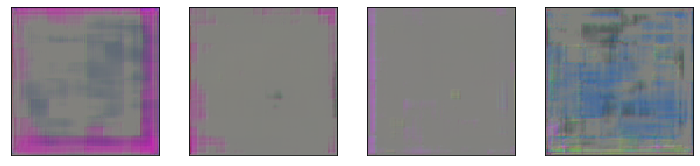

Saved model to models/model_1.pth
lrG =  0.0003
lrD =  0.0003



[2/2] D_loss = 1.525, G_loss = -0.141, elapsed_time = ? min


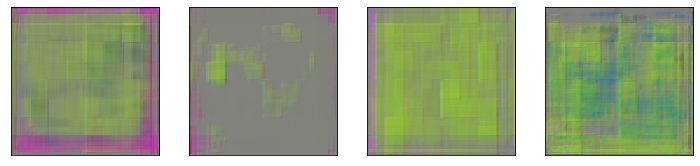

Saved model to models/model_2.pth


In [195]:
_ = trainer.train_loop(train_loader)

# Training loop

In [89]:
def run(get_model_fnc, train_loader,
        lr_G=3e-4,lr_D=3e-4, 
        beta1=0.0, beta2=0.999, 
        nz=120, epochs=2, 
        n_ite_D=1, ema_decay_rate=0.999, 
        show_epoch_list=None, 
        output_freq=10,
        model_paths='models'):
    n_classes = 0
    
    netD, netG = get_model_fnc()
    device = get_device()
    netD.to(device)
    netG.to(device)
    
    if EMA == True:
        print("Setup EMA")
        ema = EMA(ema_decay_rate)
        for name, param in netG.named_parameters():
            if param.requires_grad:
                ema.register(name, param.data) 
                
    print(count_parameters(netG))
    print(count_parameters(netD))
    
    real_label = 0.9
    fake_label = 0
    
    D_loss_list = []
    G_loss_list = []
    
    dis_criterion = nn.BCELoss().to(device)

    optimizerD = optim.Adam(netD.parameters(), lr=lr_D, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr_G, betas=(beta1, beta2))
    
    if MILESTONES is not None:
        schedulerD = optim.lr_scheduler.MultiStepLR(optimizerD, milestones=MILESTONES, 
                                                    gamma=SCHEDULER_GAMMA, last_epoch=-1)
        schedulerG = optim.lr_scheduler.MultiStepLR(optimizerG, milestones=MILESTONES, 
                                                    gamma=SCHEDULER_GAMMA, last_epoch=-1)
    
    fixed_noise = torch.randn(32, nz, 1, 1, device=device)
    netG.train()
    netD.train()

    # training here
    for epoch in range(1,epochs+1):
#         if elapsed_time(start_time) > TIME_LIMIT:
#             print(f'elapsed_time go beyond {TIME_LIMIT} sec')
#             break
        
        if MILESTONES is not None:
            print('lrG = ', schedulerG.get_lr()[0])
            print('lrD = ', schedulerD.get_lr()[0])
        
        D_running_loss = 0
        G_running_loss = 0
        for ii, data in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
            ############################
            # (1) Update D network
            ###########################
            for _ in range(n_ite_D):
                
                if LABEL_NOISE:
                    real_label = 0.9
                    fake_label = 0
                    if np.random.random() < LABEL_NOISE_PROB:
                        real_label = 0
                        fake_label = 0.9
                    
                # train with real
                netD.zero_grad()
                real_images = data.to(device, non_blocking=True) 
                batch_size  = real_images.size(0)
                dis_labels  = torch.full((batch_size, 1), real_label, device=device) #shape=(*,)
#                 aux_labels  = data['label'].long().to(device, non_blocking=True) #shape=(*,)
                dis_output  = netD(real_images) #dis shape=(*,1)
                
                if HINGE_LOSS:
                    errD_real = torch.mean(F.relu(1-dis_output))
                else:
                    errD_real  = dis_criterion(dis_output, dis_labels)
                errD_real.backward(retain_graph=True)

#                 # train with fake
                noise  = torch.randn(batch_size, nz, 1, 1, device=device)
#                 #noise = noise / noise.norm(dim=1, keepdim=True)
#                 aux_labels     = np.random.randint(0,n_classes, batch_size)
#                 aux_labels_ohe = np.eye(n_classes)[aux_labels]
#                 aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
#                 aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
#                 aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
                
                fake = netG(noise) #output shape=(*,3,64,64)
                dis_labels.fill_(fake_label)
                dis_output = netD(fake.detach())
                if HINGE_LOSS:
                    errD_fake = torch.mean(F.relu(1+dis_output))
                else:
                    errD_fake  = dis_criterion(dis_output, dis_labels)
                errD_fake.backward(retain_graph=True)
                D_running_loss += (errD_real.item() + errD_fake.item())/len(train_loader)
                optimizerD.step()

            ############################
            # (2) Update G network
            ###########################
            netG.zero_grad()
            dis_labels.fill_(real_label)  # fake labels are real for generator cost
            noise = torch.randn(batch_size, nz, 1, 1, device=device)
#             aux_labels     = np.random.randint(0,n_classes, batch_size)
#             aux_labels_ohe = np.eye(n_classes)[aux_labels]
#             aux_labels_ohe = torch.from_numpy(aux_labels_ohe[:,:,np.newaxis,np.newaxis])
#             aux_labels_ohe = aux_labels_ohe.float().to(device, non_blocking=True)
#             aux_labels = torch.from_numpy(aux_labels).long().to(device, non_blocking=True)
            fake  = netG(noise)
            
            dis_output = netD(fake)
            if HINGE_LOSS:
                errG = - torch.mean(dis_output)
            else:
                errG   = dis_criterion(dis_output, dis_labels)
            errG.backward(retain_graph=True)
            G_running_loss += errG.item()/len(train_loader)
            optimizerG.step()
        
        if MILESTONES is not None:
            schedulerD.step()
            schedulerG.step()
        
        if EMA == True:
            print("Setup EMA")
            for name, param in netG.named_parameters():
                if param.requires_grad:
                    param.data = ema(name, param.data)
        
        #log
        D_loss_list.append(D_running_loss)
        G_loss_list.append(G_running_loss)
        
        #output
        if epoch % output_freq == 0:
            print('[{:d}/{:d}] D_loss = {:.3f}, G_loss = {:.3f}, elapsed_time = ? min'.format(epoch,epochs,D_running_loss,G_running_loss))
        
            show_generate_imgs(netG,fixed_noise)
            plt.show()
            
            current_state = {
               'netG':netG,
               'netD':netD,
               'optimizer_D': optimizerD,
               'optimizer_G': optimizerG,
               'epoch': epoch
            }
            if not os.path.exists(model_paths): 
                os.makedirs(model_paths)
            save_path = os.path.join(model_paths, f'model_{epoch}.pth')
            print(f"=>\tSaved model to {save_path}")
            torch.save(current_state, 
                       save_path)
            
        if epoch % 20 == 0:
#             if not EMA:
            torch.save(netG.state_dict(), f'generator_epoch{epoch}.pth')
#             elif EMA:
#                 torch.save(netG_EMA.state_dict(), f'generator_epoch{epoch}.pth')
    
#     if not EMA:
#         torch.save(netG.state_dict(), 'generator.pth')
#     elif EMA:
#         torch.save(netG_EMA.state_dict(), 'generator.pth')
#     torch.save(netD.state_dict(), 'discriminator.pth')
    
    res = {'netG':netG,
           'netD':netD,
           'nz':nz,
           'optimizer_D': optimizerD,
           'optimizer_G': optimizerG,
           'D_loss_list':D_loss_list,
           'G_loss_list':G_loss_list,
    }
#     if EMA:
#         res['netG_EMA'] = netG_EMA
    return res

# Experiments

In [24]:
#random seeds
seed_everything()

HINGE_LOSS  = True
BATCH_SIZE  = 4
NUM_WORKERS = 4
EMA = False
LABEL_NOISE = False #True
LABEL_NOISE_PROB = 0.01

Z_DIM     = 60 #120
CODES_DIM = 10 #20

LR_G = 4*3e-4
LR_D = 4*3e-4
MILESTONES = [30,60] #None
SCHEDULER_GAMMA = 0.5

DUPLICATES = False #True

SHARPEN = False
SHARPEN_MAGNITUDE = 1

In [72]:
def get_models():
    netG = Generator(n_feat=8, codes_dim=CODES_DIM) #z.shape=(*,120)
    netD = Discriminator(n_feat=8)
    return netD, netG

In [77]:
def get_dataloader(data_path, bs, n_workers):
    base_tfs, additional_tfs = get_transforms()

    ds = MotorbikeDataset(data_path, base_tfs, additional_tfs)
    
    sampler = SubsetRandomSampler(indices=range(10))
    train_loader = DataLoader(ds,
                              batch_size=BATCH_SIZE,
                              sampler=sampler,
                              num_workers=NUM_WORKERS, pin_memory=True)
    return train_loader

In [81]:
train_loader = get_dataloader(data_path, BATCH_SIZE, NUM_WORKERS)

505673
1223298
lrG =  0.0005
lrD =  0.0002



[1/200] D_loss = 3.901, G_loss = 0.317, elapsed_time = ? min


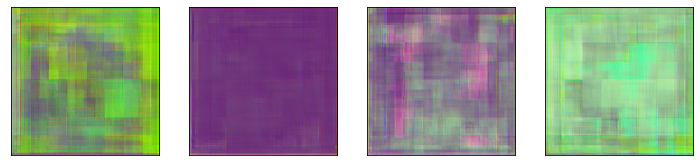

=>	Saved model to models/model_1.pth


/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResBlock_G. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


lrG =  0.0005
lrD =  0.0002


/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Discriminator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/Users/admin/anaconda3/envs/ml36/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResBlock_D. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



[2/200] D_loss = 1.716, G_loss = 1.009, elapsed_time = ? min


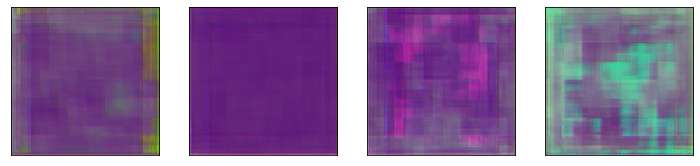

=>	Saved model to models/model_2.pth
lrG =  0.0005
lrD =  0.0002



[3/200] D_loss = 1.644, G_loss = 1.454, elapsed_time = ? min


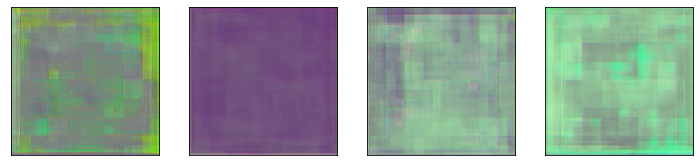

=>	Saved model to models/model_3.pth
lrG =  0.0005
lrD =  0.0002


KeyboardInterrupt: 

In [88]:
res = run(get_models, train_loader, lr_G=5e-4,lr_D=2e-4, epochs=200, n_ite_D=1, output_freq=1, model_paths='models')